In [201]:

import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split
import torch.nn.utils as nn_utils
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
  #  random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(124)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import timeit
print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

from PINNlib import *
from PINNlib import plotter as pinn_plot

cuda


**BUILD PINN, things to take care:**

*   self.get_grid(xpde) -> return q,mu,psi,I
*   self.get_der(Q,D)   -> return Q_d




In [203]:
class FCN_out(nn.Module):
    def __init__(self,layers,loss_weights=[1,1,1,1,1,1,1,1]):
        super().__init__() #call __init__ from parent class
        self.activation = nn.SiLU()  #nn.ReLU() #nn.Tanh()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        self.loss_passes = 0
        self.loss_weights = loss_weights
        self.crit = 0
        self.layers = layers
        self.crash_list = []
        for i in range(len(self.layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)
        self.crash = 0
    def weight_dec(self,x):
        res  =  (1 + torch.tanh(16*(x-0.8))) * torch.exp(-x)
        return 1 #pow((2*res),0.2)+1e-1
    def loss_function(self, inputs, targets,xdata=None):
        #self.loss_passes += 1
        #self.check(inputs,self.loss_passes)
        return nn.MSELoss(reduction='mean')(inputs, targets)
    def idx(self,tensor,nu=15):
        return np.random.choice(tensor.shape[0],nu,replace=False)
    def build_tensor(self,steps, x, y):
        tensor = torch.zeros(steps, 2)
        tensor[:,0] = torch.linspace(x[0], x[1], steps)
        tensor[:,1] = torch.linspace(y[0], y[1], steps)
        return tensor
    def check(self,tensor,name):
        has_nan = torch.isnan(tensor).any().item()
        if has_nan:
            print(name, "Has NaN values:", has_nan)
        has_inf = torch.isinf(tensor).any().item()
        if has_inf:
            print(name," Has infinite values:", has_inf)

####################################
####################################
####### forward functions ##########
    def forward(self,x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        a = x.float()
        for i in range(len(self.layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a
    def forward_bcpsi(self,x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        a = x.float()
        for i in range(len(self.layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        mu       = x[:, 1:2]
        sinth    = torch.pow(1e-8+(1-mu.pow(2)),0.5)
        return a#*sinth*sinth
    def forward_bci(self,x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        a = x.float()
        for i in range(len(self.layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        mu       = x[:, 1:2]
        sinth    = torch.pow(1e-8+(1-mu.pow(2)),0.5)
        return a#*sinth*sinth

####### forward functions ##########
####################################


####################################
##########GRID######################
    def getgrid(self,g,x):
        f        = self.forward(g)
        fi       = f[:, 0] # first output
        s        = f[:, 1] # second output
        mu       = x[:, 1:2] # th coordinate (?)
        q        = x[:, 0:1] # q coordinate (?)
        return q[:,0],mu[:,0],fi,s
    def get_der(self,Q,G):
        Q_q_mu  = autograd.grad(Q, G, torch.ones([G.shape[0]]).to(device), retain_graph=True, create_graph=True)[0]
        return Q_q_mu[:, 0:1][:,0],Q_q_mu[:, 1:2][:,0]


    def get_1st_der(self,x):
        g               = x.clone()
        g.requires_grad = True  #we will dif it
        q,mu,fi,i       = self.getgrid(g,x)
        i_q, i_mu       = self.get_der(i,g)
        f_q, f_mu       = self.get_der(fi,g)
        return q,mu,fi,i,i_q, i_mu,f_q, f_mu

    def get_all_der(self,x):
        g               = x.clone()
        g.requires_grad = True  #we will dif it
        q,mu,fi,i       = self.getgrid(g,x)
        i_q, i_mu       = self.get_der(i,g)
        f_q, f_mu       = self.get_der(fi,g)
        f_muq, f_mumu   = self.get_der(f_mu,g)
        f_qq, f_qmu     = self.get_der(f_q,g)
        return  q,mu,fi,i,i_q, i_mu,f_q, f_mu,f_muq, f_mumu,f_qq, f_qmu
####################################
############Get Pressure############
    def get_pressure(self,x_bound):
        q,mu,f,s,s_q, s_mu,f_q, f_mu = self.get_1st_der(x_bound)
        par = 1-mu**2
        pressure = (q*q-par)*(q**2*par*f_q**2 + 4 *mu**2 * f**2+ par**2*f_mu**2 - 4*mu*par*f*f_mu) + par*s**2
        return pressure
####################################
####################################
    def lossPDE(self,x_PDE):
        #get the solution as a copy, to not mess up stff


######################### pde loss#################################
        g               = x_PDE.clone()
        g.requires_grad = True  #we will dif it
        #get_grid
        q,mu,f,s,s_q, s_mu,f_q, f_mu,f_muq, f_mumu,f_qq, f_qmu   = self.get_all_der(x_PDE)


        par            = (1-mu**2)
        source         = s * (  s_q**2*par*q**2 + (2*mu*s-par*s_mu)**2 + 1e-14)**0.5 /  ( (f_q**2*par*q**2 + (-2*mu*f+par*f_mu)**2 + 1e-14)**0.5   )
        source         = source * torch.sign(s_q*f_q*q**2*par + (2*mu*s-par*s_mu)*(2*mu*f-par*f_mu))


        pde            = (q**2 - par) *(q**2 * f_qq+par*f_mumu) + 2*q**3*f_q - f*(4*mu**2 + 2*(q**2-par)) \
                          + f_mu*(2*mu*par- 4*mu*(q**2 - par)) + source
        pde            = pde * self.weight_dec(q)
        pde            = self.loss_weights[1] * pde
        loss_pde.append(self.loss_function(pde,torch.zeros_like(pde)).detach().cpu().numpy().tolist())
######################### pde loss#################################


####################### psi // i contours ########################
        parallel =  f_q * ( - 2* mu * s + par*s_mu) - s_q * (-2*mu*f +par * f_mu)
        parallel = parallel/(f**2+1e-8)* self.weight_dec(q)         #* (1.3*q)**7
        loss_parallel.append( self.loss_weights[2] *  self.loss_function(parallel, torch.zeros_like(parallel)).detach().cpu().numpy().tolist())
        parallel =  self.loss_weights[2] *  self.loss_function(parallel, torch.zeros_like(parallel))


####################### psi // i contours ########################

################### psi const ls +################################
        Y_eq = self.build_tensor(200,[1/Eval(torch.zeros(1)).detach().numpy()[0],0],[0,0])
        Y_eq = Y_eq[self.idx(Y_eq)].to(device)

        _,_,feq,_,_,_,_,_ = self.get_1st_der(Y_eq)

        psi_loss = self.loss_weights[4]*self.loss_function(feq, torch.ones_like(feq)*(1-mu_pc**2))
        loss_Psir.append(self.loss_weights[4]*self.loss_function(feq, torch.ones_like(feq)*(1-mu_pc**2)).detach().cpu().numpy().tolist())
################### psi const ls +################################



        return  self.loss_function(pde, torch.zeros_like(pde)) + \
                parallel + psi_loss

    def lossBCi(self,x_BC,y_BC):
        loss_BC = 0
        loss_temp = []
        for _,i in enumerate(x_BC):
            f = self.forward_bci(i)[:,1]
            loss_BC += self.loss_function(f,y_BC[_][:,0])
            loss_temp.append(self.loss_function(f,y_BC[_][:,0]).detach().cpu().numpy().tolist())
        loss_is.append(loss_temp)
        return loss_BC
    def lossBCpsi(self,x_BC,y_BC):
        loss_BC = 0
        loss_temp = []
        for _,i in enumerate(x_BC):
            f = self.forward_bcpsi(i)[:,0]
            loss_BC += self.loss_weights[0] * self.loss_function(f,y_BC[_][:,0])
            loss_temp.append(self.loss_weights[0] * self.loss_function((f-y_BC[_][:,0])**3,torch.zeros_like(y_BC[_][:,0])).detach().cpu().numpy().tolist())
        loss_psis.append(loss_temp)
        return loss_BC

    def lossBCpsi_sep(self,x_BC,y_BC):
        f = self.forward_bcpsi(x_BC)[:,0]
        loss_BC =  self.loss_weights[3]*self.loss_function(f*(1-x_BC[:,1]**2),y_BC[:,0])
        loss_psi_sep.append(loss_BC.detach().cpu().numpy().tolist())
        return loss_BC

    def loss(self,xp_BC,yp_BC,x_PDE,x_S,Psi_s):
        loss_bcp=self.lossBCpsi(xp_BC,yp_BC)
        loss_pdee=self.lossPDE(x_PDE)
        loss_Sep =self.lossBCpsi_sep(x_S,Psi_s)
        return  loss_pdee+loss_bcp  +loss_Sep




In [204]:
class FCN_in(nn.Module):
    def __init__(self,layers,loss_weights=[1,1,1,1,1,1,1,1]):
        super().__init__() #call __init__ from parent class
        self.activation = nn.SiLU()  #nn.ReLU() #nn.Tanh()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        self.loss_passes = 0
        self.loss_weights = loss_weights
        self.layers       = layers
        self.crit = 0
        self.crash_list = []
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)
        self.crash = 0
    def weight_dec(self,x):
        res  =  (1 + torch.tanh(16*(x-0.8))) * torch.exp(-x)
        return 1 #pow((2*res),0.2)+1e-1
    def loss_function(self, inputs, targets,xdata=None):
        #self.loss_passes += 1
        #self.check(inputs,self.loss_passes)
        return nn.MSELoss(reduction='mean')(inputs, targets)
    def idx(self,tensor,nu=15):
        return np.random.choice(tensor.shape[0],nu,replace=False)
    def build_tensor(self,steps, x, y):
        tensor = torch.zeros(steps, 2)
        tensor[:,0] = torch.linspace(x[0], x[1], steps)
        tensor[:,1] = torch.linspace(y[0], y[1], steps)
        return tensor
    def check(self,tensor,name):
        print(np.shape(tensor),name)
        has_nan = torch.isnan(tensor).any().item()
        if has_nan:
            print(name, "Has NaN values:", has_nan)
        has_inf = torch.isinf(tensor).any().item()
        if has_inf:
            print(name," Has infinite values:", has_inf)

####################################
####################################
####### forward functions ##########
    def forward(self,x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        a = x.float()
        for i in range(len(self.layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a
    def forward_bcpsi(self,x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        a = x.float()
        for i in range(len(self.layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        mu       = x[:, 1:2]
        sinth    = torch.pow(1e-8+(1-mu.pow(2)),0.5)
        return a#*sinth*sinth

####### forward functions ##########
####################################


####################################
##########GRID######################
    def getgrid(self,g,x):
        f        = self.forward(g)
        fi       = f[:, None] # first output
        mu       = x[:, 1:2] # th coordinate (?)
        q        = x[:, 0:1] # q coordinate (?)

        return q[:,0],mu[:,0],fi[:,:,0][:,0]
    def get_der(self,Q,G):
        Q_q_mu  = autograd.grad(Q, G, torch.ones([G.shape[0]]).to(device), retain_graph=True, create_graph=True)[0]
        return Q_q_mu[:, 0:1][:,0],Q_q_mu[:, 1:2][:,0]


    def get_1st_der(self,x):
        g               = x.clone()
        g.requires_grad = True  #we will dif it
        q,mu,fi         = self.getgrid(g,x)
        f_q, f_mu       = self.get_der(fi,g)
        return q,mu,fi,f_q, f_mu

    def get_all_der(self,x):
        g               = x.clone()
        g.requires_grad = True  #we will dif it
        q,mu,fi         = self.getgrid(g,x)
        f_q, f_mu       = self.get_der(fi,g)
        f_muq, f_mumu   = self.get_der(f_mu,g)
        f_qq, f_qmu     = self.get_der(f_q,g)
        return  q,mu,fi,f_q, f_mu,f_muq, f_mumu,f_qq, f_qmu
####################################
############Get Pressure############
    def get_pressure(self,x_bound):
        q,mu,f,f_q, f_mu = self.get_1st_der(x_bound)
        par = 1-mu**2
        pressure = (q*q-par)*(q**2*par*f_q**2 + 4 *mu**2 * f**2+ par**2*f_mu**2 - 4*mu*par*f*f_mu)
        return pressure
####################################
####################################
    def lossPDE(self,x_PDE):
        #get the solution as a copy, to not mess up stff


######################### pde loss#################################
        g               = x_PDE.clone()
        g.requires_grad = True  #we will dif it
        #get_grid
        q,mu,f,f_q, f_mu,f_muq, f_mumu,f_qq, f_qmu   = self.get_all_der(x_PDE)


        par            = (1-mu**2)
        pde            = (q**2 - par) *(q**2 * f_qq+par*f_mumu) + 2*q**3*f_q - f*(4*mu**2 + 2*(q**2-par)) \
                          + f_mu*(2*mu*par- 4*mu*(q**2 - par))
        pde            = pde * self.weight_dec(q)
        pde            = self.loss_weights[1] * pde
        loss_pde.append(self.loss_function(pde,torch.zeros_like(pde)).detach().cpu().numpy().tolist())
######################### pde loss#################################





        return  self.loss_function(pde, torch.zeros_like(pde))

    def lossBCpsi(self,x_BC,y_BC):
        loss_BC = 0
        loss_temp = []
        for _,i in enumerate(x_BC):
            f = self.forward_bcpsi(i)[:,0]
            loss_BC +=  self.loss_weights[0] *self.loss_function((f-y_BC[_][:,0]),torch.zeros_like(y_BC[_][:,0])).detach().cpu().numpy().tolist()
            loss_temp.append(self.loss_weights[0] * self.loss_function((f-y_BC[_][:,0]),torch.zeros_like(y_BC[_][:,0])).detach().cpu().numpy().tolist())
        loss_psis.append(loss_temp)
        return loss_BC
    def lossBCpsi_sep(self,x_BC,y_BC):
        f = self.forward_bcpsi(x_BC)[:,0]
        loss_BC = self.loss_weights[3]*self.loss_function(f*(1-x_BC[:,1]**2),y_BC[:,0])
        loss_psi_sep.append(loss_BC.detach().cpu().numpy().tolist())
        return loss_BC

    def loss(self,xp_BC,yp_BC,x_PDE,x_S,Psi_s):
        loss_bcp =self.lossBCpsi(xp_BC,yp_BC)
        loss_pdee=self.lossPDE(x_PDE)
        loss_Sep =self.lossBCpsi_sep(x_S,Psi_s)
        return  loss_pdee+loss_bcp+ loss_Sep

In [273]:
class FCN_equalizer(nn.Module):
    def __init__(self):
        super(FCN_equalizer, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
        self.activation = nn.SiLU()
    def loss_function(self, inputs, targets,xdata=None):
        return nn.MSELoss(reduction='mean')(inputs, targets)
    def forward(self, x):
        mu = x.clone()
        x  = torch.relu(self.fc1(x))
        x  = torch.relu(self.fc2(x))
        x  = self.fc3(x)
        f  = r_star +  (1 -  (mu/mu_pc)**2)*x**2
        return f
    def get_der(self,Q,G):
        Q_q_mu  = autograd.grad(Q, G, torch.ones([G.shape[0]]), retain_graph=True, create_graph=True)
        return Q_q_mu
    def get_1st_der(self,x):
        g               = x.clone()
        g.requires_grad = True  #we will dif it
        f               = self.forward(g)
        f_mu            = self.get_der(f[:,0],g)
        return f_mu
    
    def loss(self,mu_s,pin, pout):
        p_loss = self.loss_function(pin,pout)
        f_mu   = self.get_1st_der(mu_s)[0]  
        f      = self.forward(mu_s)    
        maxq    = f - 1
        maxq    = 1e14*(torch.abs(maxq)+maxq)[:,0]
        maxd    = 1e14*(torch.abs(f_mu )+f_mu)[:,0]

        
        
        
        return  p_loss + self.loss_function(maxq, torch.zeros_like(maxq)) + self.loss_function(maxd, torch.zeros_like(maxd))
    
    def printloss(self,mu_s,pin, pout):
        p_loss = self.loss_function(pin,pout)
        f_mu   = self.get_1st_der(mu_s)[0]
        f      = self.forward(mu_s)   
        maxq    = f - 1
        maxq    = 1e10*(torch.abs(maxq)+maxq)
        maxd    = 1e10*(torch.abs(f_mu )+f_mu)
        return  p_loss,self.loss_function(maxq, torch.zeros_like(maxq)),self.loss_function(maxd, torch.zeros_like(maxd))        
        

r_star   = 0.1

In [274]:
### train the PINN to be initialized like
Eval = FCN_equalizer()
mu_pc = np.cos(  1.3* r_star**0.5  /  1**0.5  )
optimizer = optim.Adam(Eval.parameters(), lr=0.001)
mu_train = torch.linspace(-mu_pc,  mu_pc, 1000).unsqueeze(1)  # Generate 100 equally spaced points between 0 and 2*pi

def r_init(mu):
    sin2pc= (1-mu_pc**2)
    sin2th= (1-mu**2)
    result = np.where(np.abs(mu) < np.abs(mu_pc), r_star * sin2th / sin2pc, r_star)
    return result

y_train = r_init(mu_train)  # Compute the corresponding sin(x) values

num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = Eval(torch.abs(mu_train))
    loss = Eval.loss_function(outputs, torch.from_numpy(y_train))
    loss.backward()
    optimizer.step()



In [275]:
def sep_plot():
    mu_train = torch.linspace(-mu_pc,  mu_pc, 1000).unsqueeze(1)  # Generate 1000 equally spaced points between 0 
                                                                  # and 2*pi
    y_test = Eval(torch.abs(mu_train))
    y_test2 = Eval.loss(torch.abs(mu_train),torch.zeros_like(mu_train),torch.zeros_like(mu_train))

    # Plot the results
    import matplotlib.pyplot as plt
    plt.plot(mu_train, y_test.detach().numpy(),linestyle='-.', label='PINN')
    plt.plot(mu_train, r_init(mu_train),linestyle='--', label='Training Data')
    plt.xlabel('x')
    plt.ylabel('r(x)')
    plt.legend()
    plt.show()



FUNCTIONS HAVE BEEN DEFINED, NOW THE REST CODE. FROM CODE UP, U ONLY NEED TO CHANGE THE ***FCN***


**BUILD THE GRID FOR YOUR PDE**



*   Q,MU are used for the star_b grid. You should be able to change it to build tensor. Add enough points to sample from.
*   Should be turned into a function to return grid and be put on lib file for this to be more compact




In [276]:
# To generate new data:
global q_min,q_man,mu_min,mu_max,q_ls,q_y
q_min  = 0.0
q_max = 1.0/r_star
mu_min = -1
mu_max = 1
q_ls   = 1.0 # where the light cyl lands
q_y    = 1.0/0.9 # where the Y point landsCC

# Create two grids: so more points inside the star
mu = torch.linspace(mu_min, mu_max, 400)
q  = torch.linspace(q_min, q_max , 400)
## set ranges of the variables

Q,MU = torch.meshgrid(q,mu)


## costruct the data in proper form (seems clunky but pytorch
grid_data = torch.hstack((Q.transpose(1,0).flatten()[:,None],MU.transpose(1,0).flatten()[:,None]))

In [277]:
lb1 = grid_data[0] #first value
ub1 = grid_data[-1] #last value
ub1[0] = q_max  # fix the first grid (manually but yeah)



## we want to sample from two "spaces". therefore those fixes ^
print(lb1,ub1)

tensor([ 0., -1.]) tensor([10.,  1.])


**BUILD BOUNDARY CONDITIONS**

---



1.   Change stff to build_tensors
2.   Class them (tried but got weird results Classed.ipynb)



In [278]:
star_b = torch.hstack((Q[-1,:][:,None],MU[-1,:][:,None])) # the last row of Q, which coincides with star (r = r* , th)
#ls_b   = torch.hstack((Q[len(q1)-1,:][:,None],MU[len(q1)-1,:][:,None])) # the light cylinder (r = r_ls , th)
#ax_p   = torch.hstack((Q[:,0][:,None],MU[:,0][:,None]))#[1:-1] # the first row of TH, which coinsides with inf (r , th=0)
#ax_m   = torch.hstack((Q[:,-1][:,None],MU[:,-1][:,None]))#[1:-1] # the first row of TH, which coinsides with inf (r , th=pi)
#Y_eq   = build_tensor(400,[q_max,0],[0,0]) # build a tensor from rstar -> rYpoint, and mu = 0 -> theta = pi/2


In [279]:


psi_max = 1 # max flux
psi_starb = torch.ones_like(star_b[:,1].unsqueeze(1) ) #psi_max* ( 1-(star_b[:,1]).unsqueeze(1)**2 )



psi_bound_x  =[star_b]   # for boundarys of Psi, the grid cooridantes
psi_bound_val=[psi_starb]   # for boundarys of Psi, the grid cooridantes


**BUILD THE LISTS TO SAVE THE PLOTTABLE LOSS DATA AND PLOT FUNCTIONS**

*   PASS THEM TO FILE IN DESKOT
*   FIX MED_DICT (APPEND FLOAT IN **FCN** NOT ARRAYS/TESNORS FOR STATISTICS TO WORK)
*   MAKE SUBFUNCTION FOR EACH PLTTING QUANTITY IN PLOTTER()



In [280]:
import numpy as np
import matplotlib.pyplot as plt
import statistics
import itertools
from scipy.ndimage import gaussian_filter1d

def smooth_plot(data, label):
    smoothed_data = gaussian_filter1d(data, sigma=5)  # Apply Gaussian filter
    plt.plot(smoothed_data[-3000:], label=label, color=next(color_generator))

def get_colors():
    colors = [
        '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
    ]
    for color in itertools.cycle(colors):
        yield color

color_generator = get_colors()


def plotter():
    med_dict = {}
    plt.clf()
    plt.rcParams['lines.linewidth'] = 2.5  # Set the default linewidth
    psis = np.array(loss_psis)

    for _, i in enumerate(loss_psinames):
        smooth_plot(psis[::2, _], i+' in')
        #med_dict[i] = statistics.mean(psis[:, _])

    smooth_plot(loss_pde[::2], 'pde_in')
    smooth_plot(loss_psi_sep[::2],'sep in')
    plt.yscale('log')
    plt.title('Loss(steps)_in')
    plt.xlabel('steps')
    plt.grid()
    plt.xlim(0, None)
    plt.ylim(1e-8, None)
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.02, 1))
    plt.show()

    for _, i in enumerate(loss_psinames):
        smooth_plot(psis[1::2, _], 'Star Bound out')
    smooth_plot(loss_pde[1::2], 'pde_out')
    smooth_plot(loss_psi_sep[1::2],'sep out')
    smooth_plot(loss_parallel, 'parallel_out')
    smooth_plot(loss_Psir, 'Psi equator')
    plt.yscale('log')
    plt.title('Loss(steps)_out')
    plt.xlabel('steps')
    plt.grid()
    plt.xlim(0, None)
    plt.ylim(1e-8, None)
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.02, 1))
    plt.show()


    return 'Star Bound=',psis[-1,0],'separatrix = ', loss_psi_sep [-1], 'pde=', loss_pde[-1], 'parallel = ', loss_parallel[-1], 'Psi_Eq=', loss_Psir[-1]






**BUILD THE RANDOM POINT ASSIGNERS TO GET EACH STEP. BOTH IN TERMS OF GRID POINTS AND BOUNDARY**

*   Have large tesnors (4k points) and grab some of them each step. better than small tensors and assigning them all (more points to compute, slower)
*   Instead of random picking inside training. just do rand_bound(), rand_grid(). Assign to device inside there. That's the aim




In [281]:

psi_bound_val


nu = 55


def split(point):
    Eval.float()
    if torch.abs(point[1]) > mu_pc :
        return 0
    elif 1/Eval(torch.abs(point[1]).unsqueeze(-1).float()) > point[0] :
        return 0
    else:
        return 1


# collect  grid points from 1st boundary
def rand_bound(nu=100):
    split_bounds    = {}
    split_bounds[0] = []
    split_bounds[1] = []
    split_bounds[2] = []
    split_bounds[3] = []
    def idx(tensor,nu=nu):
        return np.random.choice(tensor.shape[0],nu,replace=False)
    PSI_list_val = []
    PSI_list_grd = []
    for _,tens in enumerate(psi_bound_val):
        temp_idx = idx(tens)
        PSI_list_val.append(tens[temp_idx].to(device))
        PSI_list_grd.append(psi_bound_x[_][temp_idx].to(device))
### split points #
    for _,k in enumerate(PSI_list_grd):
      for __,i in enumerate(k):
        #print(k,'k',_,'_',i,'i')
        #print(i)
        split_bounds[split(i.cpu())].append(i.detach().cpu().numpy())
        split_bounds[split(i.cpu())+2].append(PSI_list_val[_][__].detach().cpu().numpy())

    #print(type(split_bounds[0]),type(split_bounds[1]))
    return torch.from_numpy(np.array(split_bounds[0])),torch.from_numpy(np.array(split_bounds[0+2])) ,  torch.from_numpy(np.array(split_bounds[1])),torch.from_numpy(np.array(split_bounds[3]))  #,I_list_grd,I_list_val




# collect  grid points from 1st boundary
def rand_grid(Nf=500):
    full_grid = lb1+(ub1-lb1)*lhs(2,Nf) # use another random drawer
    split_bounds = {}
    split_bounds[0] = []
    split_bounds[1] = []
    for i in full_grid:

      split_bounds[split(i)].append(i.detach().cpu().numpy())
    Out = torch.from_numpy( np.array(split_bounds[0]) )
    In  = torch.from_numpy( np.array(split_bounds[1]) )


    return Out.to(device),In.to(device)

# collect  separatrix surface
def rand_sep(Nf=50):
    def idx(tensor,nu=Nf):
        return np.random.choice(tensor.shape[0],nu,replace=False)
    tensor = torch.zeros(10*Nf, 2)
    temp_idx = idx(tensor)
    tensor[:,1] = torch.linspace(mu_pc, -mu_pc, 10*Nf)
    with torch.no_grad():
        tensor[:,0] = 1/Eval(torch.abs(tensor[:,1].unsqueeze(1)))[:,0]

    return tensor[temp_idx].to(device)

Configure the PINN, use network, in the future according to this: https://www.sciencedirect.com/science/article/abs/pii/S0021999119308411

to avoid vanishing/exploding

In [282]:
#weights  [ 0:None , 1:None, 2:erelb, 3:parallel, 4:pde, 5: boundaries psi, 6:boundaries i]
weight_dict = {
    # name : index(leave untouched) , weight(change it)
    'Bound_psi'    : [0,   1e-1],
    'pde'    : [1,  1e1],
    'parallel'    : [2,   1e2],
    'Psi_sep': [3,    1e4],
    'Blank': [4,         1e7],
    'Blank': [5,   10],
    'Blank': [6,     1e3],
     'Blank': [7,    0],
     'Blank': [8,    1],
     'Blank': [9,    1e1]}



weightsi = np.ones(10)
for key in weight_dict:
    weightsi[weight_dict[key][0]] = weight_dict[key][1]


#weights  [ 0:None , 1:None, 2:erelb, 3:parallel, 4:pde, 5: boundaries psi, 6:boundaries i]
weight_dict = {
    # name : index(leave untouched) , weight(change it)
    'Bound_psi'    : [0,   1e2],
    'pde'    : [1,  1e1],
    'parallel'    : [2,   1e4],
    'Psi_sep': [3,    1e3],
    'psi_r': [4,         1e4],
    'Blank': [5,   1e5],
    'Blank': [6,     1e3],
     'Blank': [7,    0],
     'Blank': [8,    1],
     'Blank': [9,    1e1]}




weightso = np.ones(10)
for key in weight_dict:
    weightso[weight_dict[key][0]] = weight_dict[key][1]

In [283]:

# PINN_out.weights = weightso

In [284]:
layers_in  = np.array([2,256,256,1])
layers_out = np.array([2,256,256,256,2])
global loss_psis

loss_psis = []
loss_psinames =[r'$\Psi_Rs$']#,r'$\Psi_{-}$',r'$\Psi_{+}$']


global loss_is
loss_is     =[]
loss_inames =[r'$I_R(eq)$']#,r'$I_R(eq)$']#,r'$I_{+}$',r'$I_{-}$',r'$I_{0}$']

global loss_pde,loss_parallel,loss_eb,loss_xpde,loss_Psir,loss_Iinf,loss_lc,loss_Closed
loss_infpde,loss_pde,loss_parallel,loss_eb,loss_xpde,loss_Psir,loss_Iinf,loss_lc,loss_Closed,loss_psi_sep =[],[],[],[],[],[],[],[],[],[]

PINN_out = FCN_out(layers_out,weightso)
PINN_out.to(device)
PINN_in = FCN_in(layers_in,weightsi)
PINN_in.to(device)


## load earlier versions
PINN_in.load_state_dict(torch.load('best_fitin_test2.ph'))
PINN_in.eval()
PINN_out.load_state_dict(torch.load('best_fitout_test2.ph'))
PINN_out.eval()

FCN_out(
  (activation): SiLU()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1-2): 2 x Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [285]:

optimizer_in = torch.optim.Adam(PINN_in.parameters(),lr=1e-4,amsgrad=False)
optimizer_out = torch.optim.Adam(PINN_out.parameters(),lr=1e-4,amsgrad=False)
#optimizer = torch.optim.SGD(PINN.parameters(), lr=1e-3)

scheduler_in = ReduceLROnPlateau(optimizer_in, mode='min', factor=0.5, patience=30000, verbose=True,min_lr = 5e-6)
loss_ins = []
scheduler_out = ReduceLROnPlateau(optimizer_out, mode='min', factor=0.5, patience=30000, verbose=True,min_lr = 5e-6)
loss_ins = []
loss_ins = []
loss_outs = []


**Import Gradient tracking. Many issues with these**





In [286]:
# Add these imports
import torch.nn.utils as nn_utils

# Add these lines before your training loop
grads = []
weights2 = []

In [287]:

def second_train(steps):
    Grid_out, Grid_in                      =  rand_grid()
    psi_xout,psi_vout,psi_xin,psi_vin       = rand_bound(nu=100)
    x,y,z,t = rand_bound(40)

    Grid_out          = excluder(Grid_out,excluded_points = [[0.0, -1.0], [0.0, 1.0]])
    Grid_sep          = torch.abs(rand_sep())
    psi_s             = torch.ones_like(Grid_sep)*(1-mu_pc**2)
    pressure_in       = PINN_in.get_pressure(Grid_sep)
    print(np.shape(Grid_sep),np.shape(psi_s))
    for i in range(steps):
        # collect  grid points from 1st boundary
        ## change random points every once in a while instead of every step:




        PINN_in.iter  += 1
        PINN_out.iter += 1


        if i==0:
            print("Training Loss-----Test Loss")


    # advance in (make it funciton)
        loss_in = PINN_in.loss([psi_xin.to(device)],[psi_vin.to(device)],Grid_in,Grid_sep, psi_s)
        loss_ins.append(loss_in.detach().cpu().numpy())
        optimizer_in.zero_grad()
        loss_in.backward()
        scheduler_in.step(loss_in)
        optimizer_in.step()

    # advance out (make it funciton)
        loss_out = PINN_out.loss([torch.abs(psi_xout.to(device))],[psi_vout.to(device)],torch.abs(Grid_out),Grid_sep, psi_s)
        loss_outs.append(loss_out.detach().cpu().numpy())
        optimizer_out.zero_grad()
        loss_out.backward()
        scheduler_out.step(loss_out)
        optimizer_out.step()




    #     for p in PINN_out.parameters():
    #         if p.grad is not None:
    #             grads.append(p.grad.data.abs().mean().item())

    #     # Monitor weights

    #     for p in PINN_out.parameters():
    #         weights2.append(p.data.abs().mean().item())




        # Apply gradient clipping

        # max_norm = 10  # Set the maximum norm value
        # nn_utils.clip_grad_norm_(PINN.parameters(), max_norm)




        # check through training stff
        if i%(3000)==0:
            ##
            Grid_out, Grid_in = rand_grid()
            psi_xout,psi_vout,psi_xin,psi_vin       = rand_bound(nu=100)
            Grid_out          = excluder(Grid_out,excluded_points = [[0.0, -1.0], [0.0, 1.0]])
            Grid_sep          = rand_sep()


            psi_s             = torch.ones_like(Grid_sep)*(1-mu_pc**2)
            torch.save(PINN_in.state_dict(), 'best_fitin_test3.ph')
            torch.save(PINN_out.state_dict(), 'best_fitout_test3.ph')

        if i%(1000)==0:
            print('in',loss_in.detach().cpu().numpy(),'out',loss_out.detach().cpu().numpy())#,'---',test_loss.detach().cpu().numpy())
    pressure_in       = PINN_in.get_pressure(Grid_sep)
    pressure_out      = PINN_out.get_pressure(Grid_sep)
    return Grid_sep[:,1],pressure_in,pressure_out


###
optimizer = optim.Adam(Eval.parameters(), lr=1e-18)
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    Grid_sep,pressure_in,pressure_out =  second_train(1)
    loss = Eval.loss(torch.abs(Grid_sep).unsqueeze(1).cpu(),pressure_in.cpu(),pressure_out.cpu())
    loss.backward()
    optimizer.step()
###

torch.Size([50, 2]) torch.Size([50, 2])
Training Loss-----Test Loss
in 0.034809860388631125 out 1.7297709
torch.Size([50, 2]) torch.Size([50, 2])
Training Loss-----Test Loss
in 0.41621479378360765 out 6558.6626
torch.Size([50, 2]) torch.Size([50, 2])
Training Loss-----Test Loss
in 0.09062092497855462 out 2990.773
torch.Size([50, 2]) torch.Size([50, 2])
Training Loss-----Test Loss
in 0.2546898948224757 out 2848.9685
torch.Size([50, 2]) torch.Size([50, 2])
Training Loss-----Test Loss
in 0.17278145109714824 out 1944.3674
torch.Size([50, 2]) torch.Size([50, 2])
Training Loss-----Test Loss
in 0.08010112676131007 out 1397.5793
torch.Size([50, 2]) torch.Size([50, 2])
Training Loss-----Test Loss
in 0.13966730347534914 out 1034.3522
torch.Size([50, 2]) torch.Size([50, 2])
Training Loss-----Test Loss
in 0.15572926173242657 out 689.5038
torch.Size([50, 2]) torch.Size([50, 2])
Training Loss-----Test Loss
in 0.07957262449586584 out 575.16504
torch.Size([50, 2]) torch.Size([50, 2])
Training Loss----

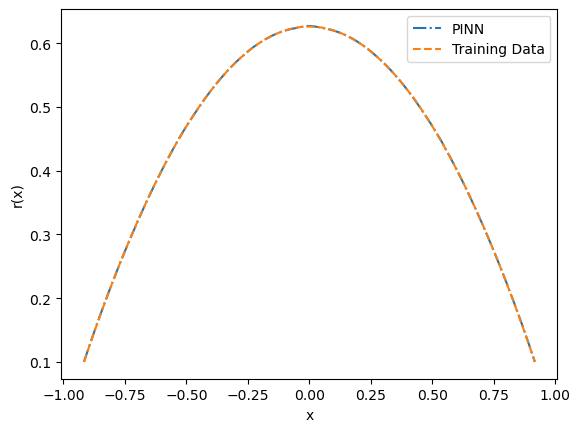

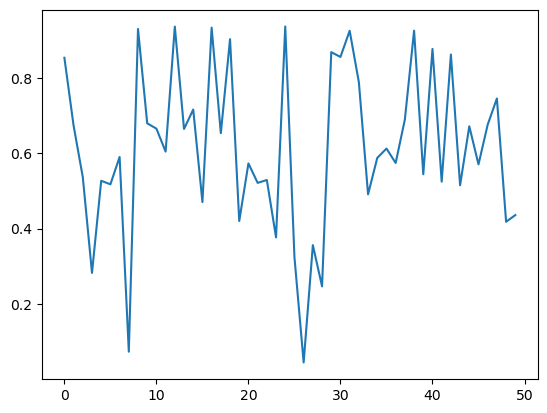

In [288]:
sep_plot()
plt.show()
press_in = pressure_in.cpu().detach().float().numpy()
press_out= pressure_out.cpu().detach().float().numpy()
plt.plot(np.abs(press_in-press_out)/[max(np.abs(press_in[i]),np.abs(press_out[i])) for i in range(len(press_in))])
plt.show()
# plt.plot(press_in)
# plt.plot(press_out)


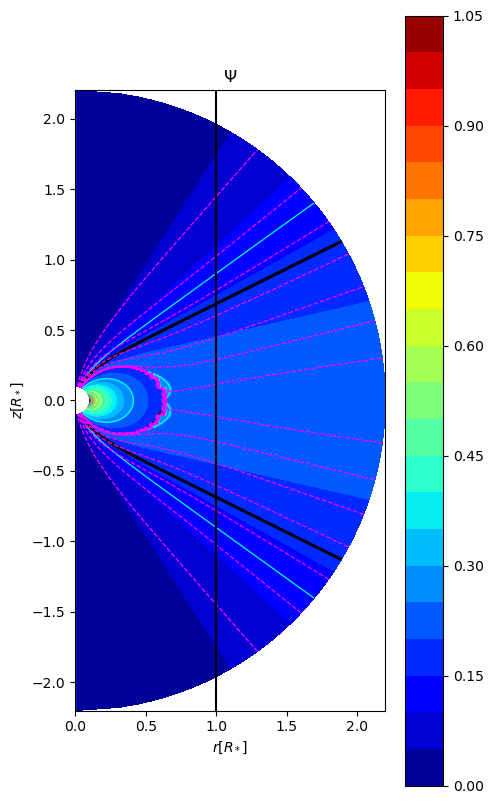

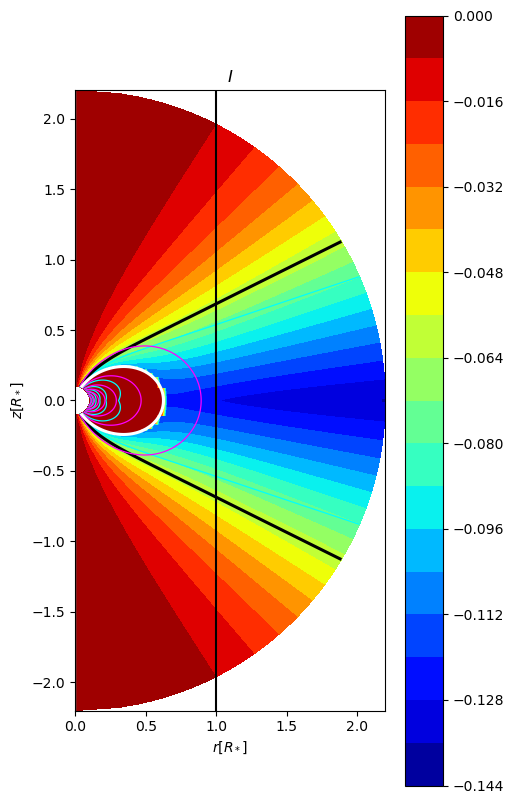

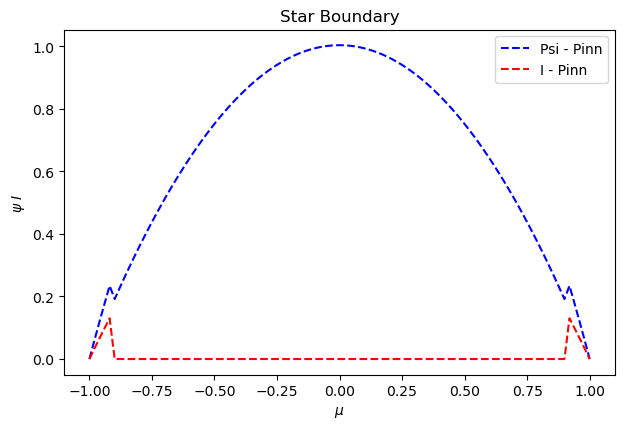

FCN_out(
  (activation): SiLU()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1-2): 2 x Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [289]:
pinn_plot(PINN_in,PINN_out,2.2,0.1,Eval,mu_pc)
PINN_in.to(device)
PINN_out.to(device)

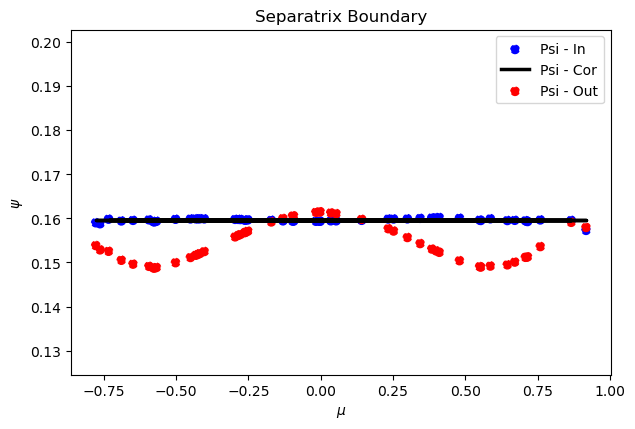

In [188]:


psi_in  =(PINN_in.forward(Grid_sep)[:,0]*(1-Grid_sep[:,1]**2).to(device)).detach().cpu().numpy()
psi_out =(PINN_out.forward(torch.abs(Grid_sep))[:,0]*(1-Grid_sep[:,1]**2).to(device)).detach().cpu().numpy()

#star
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(Grid_sep[:,1].detach().cpu().numpy(), psi_in, label='Psi - In',linestyle='--',color='b')
plt.plot(Grid_sep[:,1].detach().cpu().numpy(), np.ones(np.shape(Grid_sep[:,1].detach().cpu().numpy()))*(1-mu_pc**2), label='Psi - Cor',linestyle='-',color='black')
plt.scatter(Grid_sep[:,1].detach().cpu().numpy(), psi_out, label='Psi - Out',linestyle='--',color='r')
#plt.plot(star_b[:,1], 1-(star_b[:,1])**2, label='Psi boundary - exact',linestyle='-',color='b')
#plt.plot(X_train[:int(np.shape(X_train)[0]/Num_Bounds), 0].detach().cpu().numpy(), PINN.forward(X_train)[:int(np.shape(X_train)[0]/Num_Bounds)].detach().cpu().numpy()[:,0], label='X0 boundary',linestyle='-.')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\psi $')
plt.ylim(0.78*(1-mu_pc**2),1.27*(1-mu_pc**2))
plt.title(r'Separatrix Boundary')
plt.legend()

plt.tight_layout()
plt.show()


/tmp/ipykernel_71146/1502703546.py:21: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/eq[:,0], psi_b, label='Psi - Pinn',linestyle='--',color='b')
/tmp/ipykernel_71146/1502703546.py:22: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/eq[:,0], np.ones(np.shape(eq[:,0]))*(1-mu_pc**2), label='Psi - Polar Cup',linestyle='--',color='black')
/tmp/ipykernel_71146/1502703546.py:23: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/eq[:,0], np.abs(i_b), label='I - Pinn',linestyle='--',color='r')


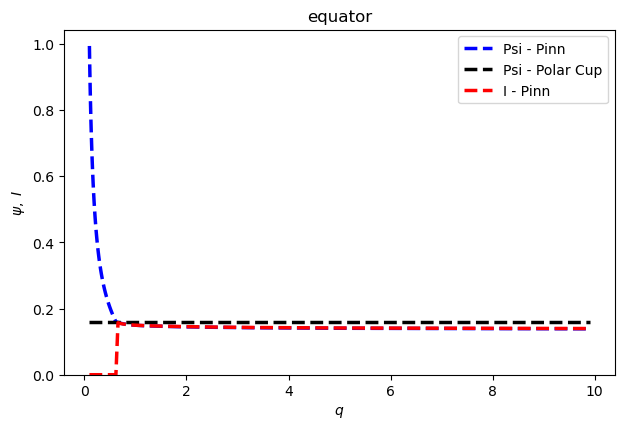

In [189]:
eq = build_tensor(100, [q_max,0],[0.1,0.1]).to(device)
QQ   = eq[:,0]
shape   = np.shape(MU.detach().cpu())
mask_out    = np.zeros(shape, dtype=bool)

for i in range(shape[0]):
    if torch.abs(QQ[i]).cpu() < 1/Eval(torch.zeros(1).to('cpu')):
        mask_out[i] = True
    else:
        mask_out[i] = False
mask_in= ~mask_out

psi_b  = (PINN_in.forward(eq)[:,0]*(1-eq[:,1]**2).to(device)).detach().cpu().numpy()*mask_in+(PINN_out.forward(torch.abs(eq))[:,0]*(1-eq[:,1]**2).to(device)).detach().cpu().numpy()*mask_out
i_b    = (0*PINN_out.forward(eq)[:,1]*(1-eq[:,1]**2).to(device)).detach().cpu().numpy()*mask_in+(PINN_out.forward(torch.abs(eq))[:,1]*(1-eq[:,1]**2).to(device)).detach().cpu().numpy()*mask_out
eq = eq.detach().cpu().numpy()                # the last row of Q, which coincides with star (r = r* , th)


#star
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(1/eq[:,0], psi_b, label='Psi - Pinn',linestyle='--',color='b')
plt.plot(1/eq[:,0], np.ones(np.shape(eq[:,0]))*(1-mu_pc**2), label='Psi - Polar Cup',linestyle='--',color='black')
plt.plot(1/eq[:,0], np.abs(i_b), label='I - Pinn',linestyle='--',color='r')
#plt.plot(star_b[:,1], 1-(star_b[:,1])**2, label='Psi boundary - exact',linestyle='-',color='b')
#plt.plot(X_train[:int(np.shape(X_train)[0]/Num_Bounds), 0].detach().cpu().numpy(), PINN.forward(X_train)[:int(np.shape(X_train)[0]/Num_Bounds)].detach().cpu().numpy()[:,0], label='X0 boundary',linestyle='-.')
plt.xlabel(r'$q$')
plt.ylabel(r'$\psi, \ I$')
plt.title(r'equator')
plt.ylim(0,None)
plt.legend()

plt.tight_layout()
plt.show()

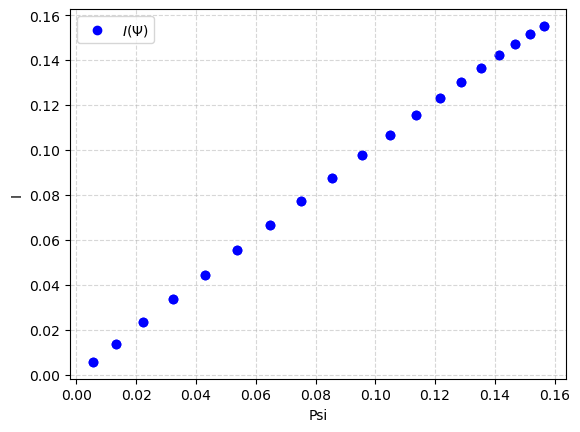

In [190]:


# LC
lc_mu      = torch.linspace(-0.999,0.999,40)[1:-1]
lc_q       = (1-lc_mu**2)**0.5
x_lc       =  torch.stack([lc_q, lc_mu], dim=1).float().to(device)
g          = torch.abs(x_lc).clone()
f          = PINN_out.forward(g)
psi        = f[:, 0].detach().cpu().numpy()*(1-lc_mu**2).detach().cpu().numpy()  # first output
I          = f[:, 1].detach().cpu().numpy()*(1-lc_mu**2).detach().cpu().numpy()  # second output





# Create the scatter plot
plt.scatter(psi, np.abs(I), color='blue', label=r'$I(\Psi)$')
plt.gca().set_aspect('auto')
# Fit a curve to the data
fit_curve = np.polyfit(psi, I, deg=2)  # You can adjust the degree of the polynomial fit
fit_func = np.poly1d(fit_curve)
x = np.linspace(min(psi), max(psi), 100)
y = fit_func(x)

# Plot the fitted curve
#plt.(x, y, color='red', label='Fitted Curve')

# Set the grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Set the aspect ratio

# Add labels and legend
plt.xlabel('Psi')
plt.ylabel('I')
plt.legend()

# Show the plot
plt.show()


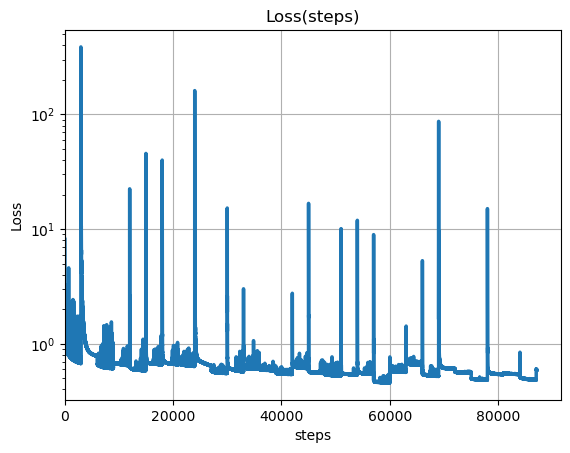

In [191]:
plt.plot(loss_outs)
plt.plot(loss_ins,'c')
plt.yscale('log')
plt.title('Loss(steps)')
plt.xlabel('steps')
plt.grid()
plt.xlim(0,)
plt.ylabel('Loss')
plt.savefig('test.png');